In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
cutoff_value = 0.99

In [2]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [3]:
print(len(u_x))

9310


In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


# Least Z Probability Calculation

In [5]:
def least_z_scores(plane, event):
    x_view, z_view, adc_view, true_z, true_x = AoI(plane, event)
    z_scores = [None] * len(x_view)
    min_z = np.amin(z_view)
    ind = np.where(min_z)[0]
    min_x = x_view[ind]
    for i in range(len(x_view)):
        z_scores[i] = (z_view[ind] - z_view[i])[0]

    score_max = max(z_scores)
    score_min = min(z_scores)
    
    normalised_scores = (z_scores - score_min) / (score_max - score_min)
    
    return normalised_scores

In [6]:
import scipy as sp
def calculate_probability_lz(plane, event, vertex):
    score = least_z_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob


# RPHI Probability Calculation

In [7]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))

def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind], score_arr

def rphi_scores(plane, event_number, function=optimise_phi, dependence=np.exp, plot=False, thresholding=True, no_std=thr_std, no_sectors=5):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number, thresholding, no_std)
    Zvert_place, Xvert_place = function(plane, event_number, no_sectors)[0], function(plane, event_number, no_sectors)[1]
    score_max, score_array = function(plane, event_number, no_sectors)[2], function(plane, event_number, no_sectors)[3]
    
    score_min = np.min(score_array)
    
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    
    if plot:
        plt.plot(AoI_z, AoI_x, 'o')
        plt.show()
        plt.plot(AoI_z, normalised_scores, 'ro')
        plt.show()
    return normalised_scores


In [8]:
import scipy as sp
def calculate_probability_rphi(plane, event, vertex):
    score = rphi_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value

    return prob

# QuadVertex Probability Calculation

In [12]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    z_point = slope1 * x_point + intercept1
    return x_point, z_point

def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, z_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if z_point > z_min and z_point < z_max:
            if angle1 < 0.8*angle2 or angle1 > 1.25*angle2: 
                return x_point, z_point
            else:
                return "fail 1", angle1, angle2
        else:
            return "fail 2"
    else:
        return "fail 3"

def get_valid_points(point1, point2, point3, point4, range_x, range_z):
    initial_vertices = [0, 0]
    try:
        initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
        #print("V1")
        return initial_vertices
    except:
        try:
            initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
            #print("V2")
            return initial_vertices
        except:
            try:
                initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                #print("V3")
                return initial_vertices
            except:
                #print("Fail", point1, point2, point3, point4) 
                return False

def select_random_points(AoI_x, AoI_z, AoI_adc, iterations="scaled", no_std=thr_std):
    if iterations == "scaled":
        iterations = int((len(AoI_x))*4)
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
    else:
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
    return initial_vertex_points

def heatmap4points(plane, event_number, thresholding=False, no_std=thr_std, iterations=10000, bins=100):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    vertex_points = vertex_points[~np.all(vertex_points == 0, axis=1)] #removes all the 0,0 vertices
    
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(bins, bins), cmap=plt.cm.jet)
    plt.title(str(plane) + str(event_number))
    plt.close()
    
    histogram_array = histvertex[0]
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]

    return z_value[0], x_value[0], histogram_array, histvertex[1], histvertex[2]

def quadvertex_scores(plane, event_number, binwidth=(100,100), binradius=3):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number)
    
    h, zedges, xedges = heatmap4points(plane, event_number)[2], heatmap4points(plane, event_number)[3], heatmap4points(plane, event_number)[4]

    zbins = np.digitize(AoI_z, zedges) - 2 
    xbins = np.digitize(AoI_x, xedges) - 2
    
    zxbins = np.concatenate((zbins[...,None],xbins[...,None]), axis=1) 
    
    weights = h[zxbins[:,0], zxbins[:,1]]
    
    scores = weights/np.amax(weights)
    return scores

'''
def findfourpointpdf(plane, events, plot=True):
    
    total_signal = []
    total_back = []
    total_r_sig = []
    total_r_back = []
    
    for ev in tqdm(events):
        signal = []
        back = []
        AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, ev)
        
        normalised_score = quadvertex_scores(plane, ev)
        #z_array, x_array = z_array[:len(z_array)-1], x_array[:len(x_array)-1]
        #print("normalised_score size: ", normalised_score.size)
        #print("z array len: ", len(z_array))
        #print("x array len: ", len(x_array))
        #print("z array: ", z_array)
        #print("x array: ", x_array)
        
        r = [None] * len(AoI_z)
        #print("\nmax normal score: ", np.max(normalised_score))
        #new_normalised_score = find_heatmap_bins(AoI_x, AoI_z, x_array, z_array, normalised_score)

        
        for i in range(len(normalised_score)):
            r[i] = ( (AoI_z[i]-Zvert_true_place)**2 + (AoI_x[i]-Xvert_true_place)**2 )**0.5
            #print("R value: ", r[i][j])
            if r[i] < 4:
                signal.append(normalised_score[i])
            else:
                back.append(normalised_score[i])
                
        total_signal.extend(signal)
        total_back.extend(back)
        
    if plot:
        
        weights_signal = np.ones(len(total_signal))
        weights_signal /= np.sum(weights_signal)
    
        weights_back = np.ones(len(total_back))
        weights_back /= np.sum(weights_back)
        
        plt.clf()
        x = plt.hist(total_signal,20, color='b', alpha=0.5, weights=weights_signal)
        title = plt.title("Signal")
        plt.show()
        
        plt.clf()
        y = plt.hist(total_back,20, color='r', alpha=0.5, weights=weights_back)
        title = plt.title("Background")
        plt.show()
        
    return total_signal, total_back, x, y
'''

sample = random.sample(range(0, len(u_x)), 3000)


In [13]:
import scipy as sp
def calculate_probability_quad(plane, event, vertex):
    score = quadvertex_scores(plane, event)[vertex]
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_quad_hist.csv", "back_quad_hist.csv")
    interpolated_function = sp.interpolate.interp1d(signal_bin, norm_signal, kind="cubic", fill_value='extrapolate')
    prob = interpolated_function(score)
    
    for i in range(0, len(prob)):
        if prob[i] >= cutoff_value:
            prob[i] = cutoff_value
    
    return prob

In [14]:
def generate_all_scores(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    r_scores = [None] * len(AoI_x)
    for i in range(len(AoI_x)):
        r_scores[i] = ((AoI_x[i] - AoI_truevtxx)**2 + (AoI_z[i] - AoI_truevtxz)**2)**(0.5)
        
    qd_scores = quadvertex_scores(plane, event)
    lz_scores = least_z_scores(plane, event)
    rp_scores = rphi_scores(plane, event)
    
    return lz_scores, rp_scores, qd_scores, r_scores

In [15]:
lz_scores, rp_scores, qd_scores, r_scores = generate_all_scores("u", 14)

In [16]:
import pandas as pd

def generate_score_dataframe(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    r_scores = [None] * len(AoI_x)
    for i in range(len(AoI_x)):
        r_scores[i] = ((AoI_x[i] - AoI_truevtxx)**2 + (AoI_z[i] - AoI_truevtxz)**2)**(0.5)
        
    qd_scores = quadvertex_scores(plane, event)
    lz_scores = least_z_scores(plane, event)
    rp_scores = rphi_scores(plane, event)
    combi_dataframe = pd.DataFrame(list(zip(lz_scores, rp_scores, qd_scores, r_scores)),columns =['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    
    return combi_dataframe

In [17]:
print(generate_score_dataframe("u", 14))

     LZ Scores  RPHI Scores  QuadVertex Scores  Distance from vertex
0     0.481124     0.323912           0.000000             71.634224
1     0.521206     0.339514           0.000000             49.137464
2     0.536890     0.438518           0.000000             41.862961
3     0.565645     0.529912           0.083333             28.023915
4     0.595271     0.765702           0.000000              9.516489
..         ...          ...                ...                   ...
512   0.593528     0.412165           0.000000             42.286304
513   0.593528     0.389918           0.000000             41.117770
514   0.592657     0.406833           0.000000             45.290970
515   0.592657     0.392056           0.000000             42.180260
516   0.592657     0.380696           0.000000             41.256376

[517 rows x 4 columns]


In [19]:
def generate_train_test_index_split(plane, length_divisor=5):
    #The train-val-test splitting is: 60-20-20
    length = len(u_x) / length_divisor
    all_events = range(0, int(round(length)))
    train_indices = random.sample(range(0, int(round(length))), int(round(0.6*length)))
    leftover_indices = [idx for idx in all_events if idx not in train_indices]
    val_indices = random.sample(leftover_indices, int(round(0.2*length)))
    test_indices = [idx for idx in leftover_indices if idx not in val_indices]
    
    return train_indices, val_indices, test_indices

def generate_train_test_split(plane, train_indices, val_indices, test_indices):
    df_train = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    df_val = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    df_test = pd.DataFrame(columns=['LZ Scores', 'RPHI Scores', 'QuadVertex Scores', 'Distance from vertex'])
    
    for i in tqdm(train_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_train = pd.concat([df_train, temp_dataframe])
        
    for i in tqdm(val_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_val = pd.concat([df_val, temp_dataframe])
        
    for i in tqdm(test_indices):
        temp_dataframe = generate_score_dataframe(plane, i)
        df_test = pd.concat([df_test, temp_dataframe])
        
    return df_train, df_val, df_test

In [20]:
train_indices, val_indices, test_indices = generate_train_test_index_split("u")

df_trainu, df_valu, df_testu = generate_train_test_split("u", train_indices, val_indices, test_indices)

df_trainu = df_trainu.dropna()
df_valu = df_valu.dropna()
df_testu = df_testu.dropna()


train_indices, val_indices, test_indices = generate_train_test_index_split("v")

df_trainv, df_valv, df_testv = generate_train_test_split("v", train_indices, val_indices, test_indices)

df_trainv = df_trainv.dropna()
df_valv = df_valv.dropna()
df_testv = df_testv.dropna()

  0%|                                                                                         | 0/1117 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  1%|▍                                                                                | 6/1117 [00:05<16:29,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

  5%|███▊                                                                            | 53/1117 [00:56<18:03,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  5%|████▏                                                                           | 59/1117 [01:03<21:29,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  5%|████▎                                  

  8%|██████▌                                                                         | 92/1117 [01:39<17:11,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  8%|██████▋                                                                         | 94/1117 [01:42<18:02,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  9%|██████▉                                                

 12%|█████████                                                                      | 129/1117 [02:20<14:30,  1.14it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▏                                                                     | 130/1117 [02:21<13:45,  1.20it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▎                                             

 16%|████████████▍                                                                  | 176/1117 [03:14<15:04,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 16%|████████████▊                                                                  | 181/1117 [03:20<18:06,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 19%|██████████████▋                                                                | 208/1117 [03:45<12:27,  1.22it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 19%|██████████████▊                                                                | 209/1117 [03:46<12:57,  1.17it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 22%|█████████████████                                                              | 241/1117 [04:18<11:45,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████                                                              | 242/1117 [04:21<21:15,  1.46s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▏                                     

 25%|███████████████████▍                                                           | 274/1117 [04:56<11:42,  1.20it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 25%|███████████████████▍                                                           | 275/1117 [04:57<10:43,  1.31it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 25%|███████████████████▌                                   

 28%|██████████████████████▎                                                        | 315/1117 [05:39<18:54,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 29%|██████████████████████▌                                                        | 319/1117 [05:46<25:22,  1.91s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 31%|████████████████████████▎                                                      | 343/1117 [06:07<10:04,  1.28it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 31%|████████████████████████▎                                                      | 344/1117 [06:07<09:40,  1.33it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local

 34%|██████████████████████████▋                                                    | 377/1117 [06:40<12:26,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|██████████████████████████▋                                                    | 378/1117 [06:41<10:57,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|██████████████████████████▉                            

 37%|████████████████████████████▊                                                  | 408/1117 [07:20<14:50,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 37%|█████████████████████████████▏                                                 | 413/1117 [07:25<12:39,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 37%|█████████████████████████████▎         

 42%|████████████████████████████████▉                                              | 465/1117 [08:16<10:45,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|████████████████████████████████▉                                              | 466/1117 [08:16<09:13,  1.18it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████                      

 46%|████████████████████████████████████▋                                          | 518/1117 [09:09<16:10,  1.62s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 47%|████████████████████████████████████▊                                          | 520/1117 [09:10<11:07,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 47%|████████████████████████████████████▉                  

 51%|████████████████████████████████████████▎                                      | 570/1117 [10:03<12:51,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|████████████████████████████████████████▍                                      | 571/1117 [10:04<10:40,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|████████████████████████████████████████▍              

 53%|██████████████████████████████████████████▏                                    | 596/1117 [10:29<07:04,  1.23it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|██████████████████████████████████████████▏                                    | 597/1117 [10:30<06:44,  1.29it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|██████████████████████████████████████████▋            

 58%|█████████████████████████████████████████████▌                                 | 644/1117 [11:11<07:00,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▌                                 | 645/1117 [11:12<07:04,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▊         

 62%|█████████████████████████████████████████████████▎                             | 697/1117 [12:07<07:23,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|█████████████████████████████████████████████████▊                             | 704/1117 [12:13<06:13,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 67%|████████████████████████████████████████████████████▊                          | 747/1117 [13:00<07:32,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 67%|█████████████████████████████████████████████████████▏                         | 752/1117 [13:03<05:21,  1.13it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|█████████████████████████████████████████████████████▍ 

 71%|███████████████████████████████████████████████████████▉                       | 791/1117 [13:53<06:49,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 71%|████████████████████████████████████████████████████████▏                      | 795/1117 [13:57<06:12,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 72%|███████████████████████████████████████████████████████

 75%|███████████████████████████████████████████████████████████▍                   | 841/1117 [14:47<05:02,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 75%|███████████████████████████████████████████████████████████▌                   | 842/1117 [14:47<04:19,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 75%|███████████████████████████████████████████████████████

 78%|█████████████████████████████████████████████████████████████▊                 | 874/1117 [15:23<04:59,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 79%|██████████████████████████████████████████████████████████████▌                | 884/1117 [15:35<03:21,  1.16it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 79%|███████████████████████████████████████████████████████

 82%|████████████████████████████████████████████████████████████████▊              | 917/1117 [16:05<03:19,  1.00it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|████████████████████████████████████████████████████████████████▉              | 919/1117 [16:07<03:48,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|███████████████████████████████████████████████████████

 85%|███████████████████████████████████████████████████████████████████▎           | 952/1117 [16:42<02:27,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 86%|███████████████████████████████████████████████████████████████████▊           | 958/1117 [16:47<01:57,  1.35it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 86%|███████████████████████████████████████████████████████

 89%|██████████████████████████████████████████████████████████████████████▎        | 995/1117 [17:24<02:18,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|██████████████████████████████████████████████████████████████████████▍        | 996/1117 [17:25<02:05,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|███████████████████████████████████████████████████████

 91%|███████████████████████████████████████████████████████████████████████▎      | 1022/1117 [17:47<01:24,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|███████████████████████████████████████████████████████████████████████▋      | 1026/1117 [17:52<01:55,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|███████████████████████████████████████████████████████

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1059/1117 [18:23<00:46,  1.25it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 95%|██████████████████████████████████████████████████████████████████████████    | 1061/1117 [18:25<00:56,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\10913

 99%|█████████████████████████████████████████████████████████████████████████████ | 1104/1117 [19:05<00:11,  1.18it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|█████████████████████████████████████████████████████████████████████████████▍| 1109/1117 [19:09<00:05,  1.44it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████

  6%|████▌                                                                            | 21/372 [00:19<04:21,  1.34it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  6%|████▊                                                                            | 22/372 [00:20<05:03,  1.15it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|█████                                  

 19%|███████████████▍                                                                 | 71/372 [01:15<05:18,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 19%|███████████████▋                                                                 | 72/372 [01:16<04:56,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|████████████████▎                      

 27%|█████████████████████▉                                                          | 102/372 [01:41<03:57,  1.14it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|██████████████████████▎                                                         | 104/372 [01:43<04:10,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|██████████████████████▌                                

 38%|██████████████████████████████▊                                                 | 143/372 [02:18<03:33,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 39%|███████████████████████████████▍                                                | 146/372 [02:22<03:50,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 40%|███████████████████████████████▊                       

C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 48%|██████████████████████████████████████▋                                         | 180/372 [02:51<02:44,  1.17it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 49%|██████████████████████████████████████▉                                         | 181/372 [02:52<02:33,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: Ru

 58%|██████████████████████████████████████████████▍                                 | 216/372 [03:26<02:54,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 59%|███████████████████████████████████████████████                                 | 219/372 [03:28<02:16,  1.12it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▋       

 71%|████████████████████████████████████████████████████████▊                       | 264/372 [04:07<01:26,  1.25it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 72%|█████████████████████████████████████████████████████████▊                      | 269/372 [04:13<01:38,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|███████████████████████████████████████

 82%|█████████████████████████████████████████████████████████████████▌              | 305/372 [04:43<01:14,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 84%|██████████████████████████████████████████████████████████████████▉             | 311/372 [04:49<01:08,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 84%|███████████████████████████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████▌     | 347/372 [05:30<00:29,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 94%|███████████████████████████████████████████████████████████████████████████▍    | 351/372 [05:34<00:21,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 95%|███████████████████████████████████████████████████████

  5%|████▎                                                                            | 20/373 [00:21<04:50,  1.21it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▋                                                                           | 26/373 [00:32<12:41,  2.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  9%|███████▏                                               

 24%|███████████████████                                                              | 88/373 [01:30<05:05,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|███████████████████▊                                                             | 91/373 [01:34<05:00,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 25%|████████████████████▍                                                            | 94/373 [01:36<04:25,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered

 35%|███████████████████████████▉                                                    | 130/373 [02:08<03:07,  1.30it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|████████████████████████████                                                    | 131/373 [02:09<02:54,  1.39it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|████████████████████████████▎                          

 41%|████████████████████████████████▌                                               | 152/373 [02:29<03:05,  1.19it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|█████████████████████████████████                                               | 154/373 [02:30<02:56,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▉                     

 51%|████████████████████████████████████████▌                                       | 189/373 [03:05<02:23,  1.28it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|████████████████████████████████████████▊                                       | 190/373 [03:06<02:21,  1.30it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|████████████████████████████████████████▉              

 69%|███████████████████████████████████████████████████████                         | 257/373 [04:21<02:20,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 69%|███████████████████████████████████████████████████████▎                        | 258/373 [04:22<01:59,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 82%|█████████████████████████████████████████████████████████████████▏              | 304/373 [05:08<01:15,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|█████████████████████████████████████████████████████████████████▋              | 306/373 [05:10<01:13,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|███████████████████████████████████████████████████████

 88%|██████████████████████████████████████████████████████████████████████▊         | 330/373 [05:40<00:37,  1.16it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|███████████████████████████████████████████████████████████████████████▏        | 332/373 [05:41<00:31,  1.30it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 90%|███████████████████████████████████████████████████████

 96%|████████████████████████████████████████████████████████████████████████████▉   | 359/373 [06:15<00:12,  1.13it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 361/373 [06:16<00:09,  1.22it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 97%|███████████████████████████████████████

  3%|██▋                                                                             | 37/1117 [00:40<17:18,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  4%|██▊                                                                             | 40/1117 [00:43<20:13,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  4%|██▉                                                    

  7%|█████▊                                                                          | 81/1117 [01:20<12:12,  1.42it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▉                                                                          | 83/1117 [01:21<12:34,  1.37it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  8%|██████▏                                                

 12%|█████████▏                                                                     | 130/1117 [02:11<15:29,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▎                                                                     | 131/1117 [02:11<14:01,  1.17it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▌                                             

 15%|████████████▏                                                                  | 173/1117 [02:52<18:11,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 16%|████████████▎                                                                  | 174/1117 [02:53<18:53,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 16%|████████████▌                          

 20%|███████████████▉                                                               | 226/1117 [03:42<12:44,  1.17it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 21%|████████████████▎                                                              | 230/1117 [03:46<13:37,  1.09it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 21%|████████████████▎                                      

 24%|██████████████████▌                                                            | 263/1117 [04:17<13:34,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|██████████████████▉                                                            | 267/1117 [04:21<12:23,  1.14it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|██████████████████▉                                    

 27%|█████████████████████▎                                                         | 302/1117 [04:55<11:39,  1.17it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▍                                                         | 303/1117 [04:56<11:00,  1.23it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▌                                 

 31%|████████████████████████▋                                                      | 349/1117 [05:42<09:49,  1.30it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|████████████████████████▊                                                      | 351/1117 [05:44<10:18,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|████████████████████████▉                              

 34%|███████████████████████████▏                                                   | 384/1117 [06:11<10:59,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|███████████████████████████▎                                                   | 387/1117 [06:14<12:21,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 35%|███████████████████████████▍           

 39%|██████████████████████████████▋                                                | 434/1117 [07:06<14:34,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 39%|██████████████████████████████▊                                                | 435/1117 [07:07<12:05,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 39%|██████████████████████████████▊                                                | 436/1117 [07:08<12:07,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered

 43%|█████████████████████████████████▋                                             | 476/1117 [07:50<07:11,  1.49it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 43%|█████████████████████████████████▉                                             | 479/1117 [07:53<07:57,  1.34it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 43%|█████████████████████████████████▉     

 47%|█████████████████████████████████████                                          | 524/1117 [08:43<06:49,  1.45it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|█████████████████████████████████████▋                                         | 532/1117 [08:55<19:34,  2.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 49%|██████████████████████████████████████▌                

 53%|█████████████████████████████████████████▌                                     | 588/1117 [09:59<07:35,  1.16it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|█████████████████████████████████████████▋                                     | 590/1117 [10:01<07:23,  1.19it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|█████████████████████████████████████████▉             

 56%|████████████████████████████████████████████▌                                  | 630/1117 [10:38<07:23,  1.10it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|████████████████████████████████████████████▋                                  | 632/1117 [10:41<08:05,  1.00s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|████████████████████████████████████████████▉          

 60%|███████████████████████████████████████████████▏                               | 668/1117 [11:22<07:00,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 60%|███████████████████████████████████████████████▎                               | 669/1117 [11:23<06:13,  1.20it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\

 63%|██████████████████████████████████████████████████▏                            | 709/1117 [12:04<07:11,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 64%|██████████████████████████████████████████████████▏                            | 710/1117 [12:05<06:23,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 68%|█████████████████████████████████████████████████████▌                         | 757/1117 [12:56<05:26,  1.10it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|█████████████████████████████████████████████████████▋                         | 759/1117 [13:00<08:16,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|█████████████████████████████████████████████████████▉ 

 72%|█████████████████████████████████████████████████████████                      | 807/1117 [13:48<04:56,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 72%|█████████████████████████████████████████████████████████▏                     | 809/1117 [13:52<07:36,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|███████████████████████████████████████████████████████

 76%|████████████████████████████████████████████████████████████                   | 850/1117 [14:45<04:41,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 77%|████████████████████████████████████████████████████████████▍                  | 855/1117 [14:56<09:07,  2.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 77%|███████████████████████████████████████

 81%|███████████████████████████████████████████████████████████████▊               | 902/1117 [15:42<03:50,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 81%|███████████████████████████████████████████████████████████████▊               | 903/1117 [15:43<03:24,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 81%|███████████████████████████████████████████████████████

 85%|██████████████████████████████████████████████████████████████████▉            | 946/1117 [16:25<02:09,  1.32it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 85%|███████████████████████████████████████████████████████████████████▎           | 952/1117 [16:31<02:21,  1.16it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 85%|███████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▉         | 989/1117 [17:14<02:03,  1.03it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|██████████████████████████████████████████████████████████████████████▎        | 995/1117 [17:23<02:12,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 92%|███████████████████████████████████████████████████████████████████████▊      | 1028/1117 [17:56<01:12,  1.22it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|████████████████████████████████████████████████████████████████████████▏     | 1033/1117 [18:00<01:11,  1.18it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 93%|███████████████████████████████████████████████████████

C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 96%|██████████████████████████████████████████████████████████████████████████▊   | 1072/1117 [18:56<00:42,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 96%|██████████████████████████████████████████████████████████████████████████▉   | 1073/1117 [18:57<00:40,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1098/1117 [19:18<00:27,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|████████████████████████████████████████████████████████████████████████████▊ | 1100/1117 [19:22<00:26,  1.54s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████

  5%|████▏                                                                            | 19/372 [00:17<04:49,  1.22it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  6%|████▌                                                                            | 21/372 [00:18<04:23,  1.33it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 16%|████████████▋                                                                    | 58/372 [01:10<04:24,  1.19it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 16%|████████████▊                                                                    | 59/372 [01:11<04:11,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 17%|█████████████▋                                         

 30%|███████████████████████▊                                                        | 111/372 [02:03<04:21,  1.00s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|█████████████████████████▏                                                      | 117/372 [02:10<04:39,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|█████████████████████████▌                             

 40%|████████████████████████████████▎                                               | 150/372 [02:39<02:45,  1.34it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▍                                               | 151/372 [02:40<02:53,  1.27it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▉                      

 51%|████████████████████████████████████████▍                                       | 188/372 [03:17<02:28,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|█████████████████████████████████████████                                       | 191/372 [03:20<03:06,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|█████████████████████████████████████████▉             

 60%|████████████████████████████████████████████████▏                               | 224/372 [04:00<02:34,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|████████████████████████████████████████████████▍                               | 225/372 [04:00<02:17,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 61%|████████████████████████████████████████████████▊      

 69%|███████████████████████████████████████████████████████▍                        | 258/372 [04:28<01:34,  1.20it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 70%|███████████████████████████████████████████████████████▋                        | 259/372 [04:29<01:25,  1.32it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 71%|███████████████████████████████████████████████████████

 82%|█████████████████████████████████████████████████████████████████▍              | 304/372 [05:22<01:04,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|█████████████████████████████████████████████████████████████████▌              | 305/372 [05:23<00:55,  1.20it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 94%|███████████████████████████████████████████████████████████████████████████▍    | 351/372 [06:12<00:22,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 95%|███████████████████████████████████████████████████████████████████████████▋    | 352/372 [06:14<00:22,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 95%|███████████████████████████████████████████████████████

  8%|██████▋                                                                          | 31/373 [00:37<05:39,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  9%|███████▏                                                                         | 33/373 [00:39<04:56,  1.15it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 10%|████████▎                                                                        | 38/373 [00:43<04:34,  1.22it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_poin

 28%|██████████████████████▎                                                         | 104/373 [02:03<04:33,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|██████████████████████▌                                                         | 105/373 [02:04<04:27,  1.00it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 29%|███████████████████████▏                               

 36%|█████████████████████████████▏                                                  | 136/373 [02:33<03:40,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 37%|█████████████████████████████▌                                                  | 138/373 [02:35<03:31,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 37%|█████████████████████████████▊                         

 45%|████████████████████████████████████▏                                           | 169/373 [03:07<03:18,  1.03it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 46%|████████████████████████████████████▉                                           | 172/373 [03:11<04:23,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 46%|█████████████████████████████████████  

 59%|███████████████████████████████████████████████▍                                | 221/373 [03:59<01:55,  1.32it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▌                                | 222/373 [03:59<01:47,  1.40it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 60%|███████████████████████████████████████

 71%|█████████████████████████████████████████████████████████                       | 266/373 [04:45<01:30,  1.18it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 72%|█████████████████████████████████████████████████████████▋                      | 269/373 [04:48<01:30,  1.15it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|███████████████████████████████████████████████████████

 84%|███████████████████████████████████████████████████████████████████▎            | 314/373 [05:39<01:21,  1.38s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 84%|███████████████████████████████████████████████████████████████████▌            | 315/373 [05:40<01:09,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 85%|███████████████████████████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████████▋       | 339/373 [06:10<00:38,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 91%|████████████████████████████████████████████████████████████████████████▉       | 340/373 [06:11<00:33,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|███████████████████████████████████████████████████████

# BDT Creation - Loading the datasets

In [21]:
df_trainu.to_csv("df_trainu.csv")
df_valu.to_csv("df_valu.csv")
df_testu.to_csv("df_testu.csv")


df_trainv.to_csv("df_trainv.csv")
df_valv.to_csv("df_valv.csv")
df_testv.to_csv("df_testv.csv")


In [22]:
train_indices, val_indices, test_indices = generate_train_test_index_split("w")

df_trainw, df_valw, df_testw = generate_train_test_split("w", train_indices, val_indices, test_indices)

df_trainw = df_trainw.dropna()
df_valw = df_valw.dropna()
df_testw = df_testw.dropna()

df_trainw.to_csv("df_trainw.csv")
df_valw.to_csv("df_valw.csv")
df_testw.to_csv("df_testw.csv")


  0%|▎                                                                                | 4/1117 [00:06<30:31,  1.65s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▍                                                                                | 6/1117 [00:08<25:13,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▌                                                      

  3%|██▌                                                                             | 35/1117 [00:40<23:59,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  3%|██▋                                                                             | 37/1117 [00:41<20:02,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  3%|██▋                                    

  7%|█████▊                                                                          | 81/1117 [01:53<30:23,  1.76s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▊                                                                          | 82/1117 [01:54<25:18,  1.47s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  8%|██████                                 

C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 12%|█████████                                                                      | 129/1117 [02:55<21:37,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▎                                                                     | 131/1117 [02:57<19:34,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 15%|███████████▉                                                                   | 168/1117 [03:49<21:40,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|███████████▉                                                                   | 169/1117 [03:49<17:59,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|████████████                                           

 20%|███████████████▋                                                               | 221/1117 [04:37<13:47,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|███████████████▊                                                               | 224/1117 [04:39<13:10,  1.13it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|████████████████                                       

 24%|███████████████████                                                            | 269/1117 [05:32<16:32,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|███████████████████▏                                                           | 271/1117 [05:35<18:54,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 25%|███████████████████▍                   

 27%|█████████████████████▋                                                         | 306/1117 [06:09<11:45,  1.15it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▋                                                         | 307/1117 [06:10<12:39,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|█████████████████████▊                                 

 32%|████████████████████████▉                                                      | 352/1117 [07:01<13:10,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|█████████████████████████                                                      | 354/1117 [07:03<11:52,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|█████████████████████████                              

 36%|████████████████████████████▌                                                  | 404/1117 [08:02<14:23,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▋                                                  | 405/1117 [08:03<12:36,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▋                          

 41%|████████████████████████████████▍                                              | 459/1117 [09:02<11:55,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▌                                              | 460/1117 [09:03<10:32,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|████████████████████████████████▉                      

 47%|████████████████████████████████████▊                                          | 521/1117 [10:20<11:09,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 47%|████████████████████████████████████▉                                          | 522/1117 [10:21<10:11,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314

 50%|███████████████████████████████████████▋                                       | 561/1117 [11:03<09:46,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 50%|███████████████████████████████████████▊                                       | 563/1117 [11:06<10:21,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 50%|███████████████████████████████████████▉               

 53%|█████████████████████████████████████████▌                                     | 587/1117 [11:31<12:37,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|██████████████████████████████████████████                                     | 594/1117 [11:41<10:06,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 53%|███████████████████████████████████████

 57%|████████████████████████████████████████████▊                                  | 634/1117 [12:27<07:46,  1.03it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|████████████████████████████████████████████▉                                  | 636/1117 [12:28<07:19,  1.09it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|█████████████████████████████████████████████          

 60%|███████████████████████████████████████████████▍                               | 670/1117 [13:04<08:34,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▍                               | 671/1117 [13:05<07:59,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 61%|████████████████████████████████████████████████▏      

 65%|███████████████████████████████████████████████████▏                           | 724/1117 [14:00<06:29,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 65%|███████████████████████████████████████████████████▎                           | 726/1117 [14:03<07:38,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 65%|███████████████████████████████████████████████████▍   

 68%|██████████████████████████████████████████████████████                         | 765/1117 [15:03<05:24,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 69%|██████████████████████████████████████████████████████▍                        | 770/1117 [15:09<07:47,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 69%|██████████████████████████████████████████████████████▌

 73%|█████████████████████████████████████████████████████████▍                     | 812/1117 [16:02<06:27,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|█████████████████████████████████████████████████████████▌                     | 814/1117 [16:05<06:08,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|███████████████████████████████████████████████████████

 76%|███████████████████████████████████████████████████████████▊                   | 846/1117 [16:39<05:01,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|███████████████████████████████████████████████████████████▉                   | 847/1117 [16:40<04:40,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|███████████████████████████████████████████████████████

 80%|██████████████████████████████████████████████████████████████▉                | 890/1117 [17:40<06:16,  1.66s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|███████████████████████████████████████████████████████████████                | 892/1117 [17:43<05:34,  1.49s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|███████████████████████████████████████████████████████

 83%|█████████████████████████████████████████████████████████████████▎             | 923/1117 [18:10<03:01,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|█████████████████████████████████████████████████████████████████▍             | 925/1117 [18:12<03:16,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 83%|█████████████████████████████████████████████████████████████████▋             | 929/1117 [18:16<02:59,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_poin

 86%|████████████████████████████████████████████████████████████████████▏          | 964/1117 [18:58<03:24,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|████████████████████████████████████████████████████████████████████▍          | 967/1117 [19:00<02:09,  1.16it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|███████████████████████████████████████████████████████

 90%|██████████████████████████████████████████████████████████████████████▎       | 1007/1117 [19:43<02:13,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 90%|██████████████████████████████████████████████████████████████████████▍       | 1009/1117 [19:45<02:04,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 91%|███████████████████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1065/1117 [20:59<01:02,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 96%|██████████████████████████████████████████████████████████████████████████▌   | 1067/1117 [21:00<00:50,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 96%|███████████████████████████████████████████████████████

  1%|▍                                                                                 | 2/372 [00:01<04:58,  1.24it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  2%|█▊                                                                                | 8/372 [00:08<07:37,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  3%|██▍                                                    

 12%|█████████▎                                                                       | 43/372 [00:47<07:05,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 12%|█████████▌                                                                       | 44/372 [00:48<06:41,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|███████████▉                           

 26%|████████████████████▋                                                            | 95/372 [01:48<05:18,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|█████████████████████                                                            | 97/372 [01:49<04:03,  1.13it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|█████████████████████▎                                 

 37%|█████████████████████████████▏                                                  | 136/372 [02:34<04:45,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▉                                               | 153/372 [02:54<04:09,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|█████████████████████████████████                      

 50%|████████████████████████████████████████▏                                       | 187/372 [03:38<06:47,  2.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 51%|████████████████████████████████████████▋                                       | 189/372 [03:40<05:09,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 62%|█████████████████████████████████████████████████▋                              | 231/372 [04:49<02:20,  1.00it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 63%|██████████████████████████████████████████████████                              | 233/372 [04:53<03:13,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|███████████████████████████████████████

 75%|████████████████████████████████████████████████████████████                    | 279/372 [05:48<01:27,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 75%|████████████████████████████████████████████████████████████▏                   | 280/372 [05:49<01:18,  1.18it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 87%|█████████████████████████████████████████████████████████████████████▏          | 322/372 [06:31<00:54,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 88%|██████████████████████████████████████████████████████████████████████▎         | 327/372 [06:36<00:54,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 362/372 [07:14<00:12,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|██████████████████████████████████████████████████████████████████████████████▎ | 364/372 [07:16<00:08,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████

 13%|██████████▏                                                                      | 47/373 [01:09<07:25,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 14%|███████████                                                                      | 51/373 [01:14<06:34,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 15%|████████████▍                                                     

 27%|█████████████████████▍                                                          | 100/373 [02:12<04:34,  1.00s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▋                                                          | 101/373 [02:13<04:38,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 27%|█████████████████████▉                 

 34%|██████████████████████████▊                                                     | 125/373 [02:42<03:59,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|███████████████████████████▋                                                    | 129/373 [03:00<16:06,  3.96s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|███████████████████████████▉                           

 46%|████████████████████████████████████▋                                           | 171/373 [03:47<03:50,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 46%|████████████████████████████████████▉                                           | 172/373 [03:48<03:30,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 47%|█████████████████████████████████████▎ 

 61%|████████████████████████████████████████████████▍                               | 226/373 [04:47<01:51,  1.32it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 61%|████████████████████████████████████████████████▋                               | 227/373 [04:48<01:47,  1.35it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 72%|█████████████████████████████████████████████████████████▋                      | 269/373 [05:35<01:44,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 73%|██████████████████████████████████████████████████████████                      | 271/373 [05:38<01:57,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 74%|███████████████████████████████████████

 81%|████████████████████████████████████████████████████████████████▌               | 301/373 [06:12<01:07,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 82%|█████████████████████████████████████████████████████████████████▏              | 304/373 [06:16<01:15,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|███████████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████████▋       | 339/373 [06:57<00:40,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 92%|█████████████████████████████████████████████████████████████████████████▎      | 342/373 [06:59<00:33,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:113: RuntimeWarning: invalid value encountered in divide
  scores = weights/np.amax(weights)
 99%|███████████████████████████████████████████████████████████████████████████████▎| 370/373 [07:32<00:03,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████████████████████████████▌| 371/373 [07:34<00:02,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25548\1091305314.py:8: Runt

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
x_train, y_train = df_train[['LZ Scores', 'RPHI Scores', 'QuadVertex Scores']], df_train[['Distance from vertex']]
x_val, y_val = df_val[['LZ Scores', 'RPHI Scores', 'QuadVertex Scores']], df_val[['Distance from vertex']]

In [ ]:
x_train.describe()
y_train.describe()

In [ ]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
model = DecisionTreeRegressor(max_leaf_nodes=50, random_state=0)
# Fit the BDT to the training set
model.fit(x_train, y_train)

In [ ]:
preds_val = model.predict(x_val)
mae = mean_absolute_error(y_val, preds_val)

In [ ]:
print(mae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(x_train, y_train)
preds = forest_model.predict(x_val)
print(mean_absolute_error(y_val, preds))

C:\Users\alexg\AppData\Local\Temp\ipykernel_10224\2088040020.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_10224\2088040020.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1


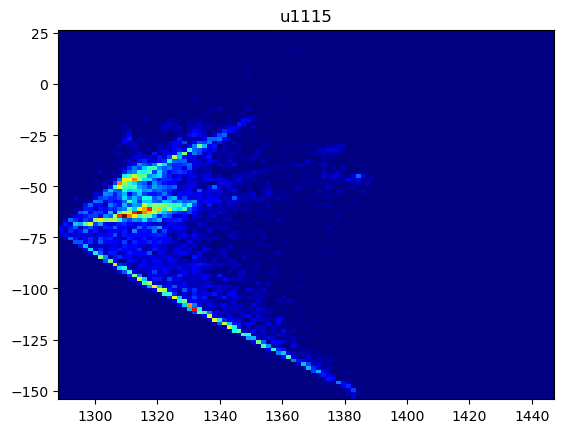

In [17]:
test_u14_dataframe = generate_score_dataframe("u", 1115)
test_u14_dataframe.to_csv("test_u1115_dataframe.csv")